# Imports

In [3]:
import random
import multiprocessing
import time
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Auxiliary Functions

In [5]:
def Average(lst):
    return sum(lst) / len(lst)

def readFile():
    # The dataset are going to be stored at a list of dictionaries
    list_of_dictionaries = []
    
    file = open("/content/drive/MyDrive/Colab Notebooks/dataset_100_500.txt", "r")


    for line in file:
        
        # Delete the \n at the file
        split_line = line.strip('\n')
        # Delete the : at the file
        split_line = split_line.split(':')

        dictionary = {}

        # We iterate among the list to obtain the event and the epoch, for every patient we have one dictionary
        for pair in split_line:
            
            event = pair[0]

            epoch = pair[2:]

            # The event is the key of the dictionary and the epoch the value.
            if event in dictionary:
                dictionary[event].append(epoch)
                
            else:
                dictionary[event] = list()
                dictionary[event].append(epoch)

        list_of_dictionaries.append(dictionary)


    return list_of_dictionaries

# Fitness Function

In [6]:
def evaluateSolution(solution, events, list_of_dictionaries, length):

    total = 0
    frequency = 0
    
    for dictionary in list_of_dictionaries:
        
        #equal = 0
        last_epoch = 0
        count = 0    
        diff_letters = 0

        iterations = {'A':0,'B':0,'C':0,'D':0,'E':0,'F':0,'G':0,'H':0,'I':0,'J':0,'K':0,'L':0,'M':0,'N':0,'O':0,'P':0,'Q':0,'R':0,'S':0,'T':0}

       # print(element)
        for element in solution:
            try:

                if type(element) == list:
                
                    epoch_1 = dictionary.get(element[0])
                    epoch_2 = dictionary.get(element[1])

                    if epoch_1 and epoch_2:                      
                    
                        index = iterations[element[0]]
                        
                        if int(epoch_1[index]) >= int(last_epoch) and epoch_1 == epoch_2:

                            total += 1
                            count += 1

                            last_epoch = epoch_1[int(iterations[element[0]])]

                            if element[0] == element[1]:
                                
                                iterations[element[0]] += 1

                            else:
                                
                                iterations[element[0]] += 1
                                iterations[element[1]] += 1
                        else:
                          total -= 1
                          count -= 1
                    else:
                      total -= 1
                      count -= 1 
                else:

                    epoch = dictionary.get(element)

                    if epoch:                   
                    
                        index = iterations[element]
                    
                        if int(epoch[int(index)]) >= int(last_epoch):
                    
                            total += 1
                            count += 1
                        
                            last_epoch = int(epoch[int(iterations[element])])

                            iterations[element] += 1

                        else:

                            total -= 1
                            count -= 1

                        if index == 0:
                          diff_letters += 1
   
            except IndexError:
                total -= 1
                count -= 1
            
                    

            if count == length:
                frequency += 1


    #Returns the number of times that you find the events and penalize it when it doesnt match.
    return total/length, frequency, diff_letters

# Hill Climbing Code

In [7]:
def getBestNeighbor(solution, data, events, list_of_dictionaries):
    ##Get the neighbors
    neighbors = []
    l=len(solution[0])

    for i in range(l):
        for j in range(i+1, l):
            n = solution[0].copy()
            n[i] = solution[0][j]
            n[j] = solution[0][i]
            neighbors.append(n)
            
    ##Get the best neighbor
    bestNeighbor = neighbors[0]
    ##evaluateSolution(solutions,events,list_of_dictionaries, len(solutions) )
    bestTotal,bestFrequency,bestNEvents = evaluateSolution(bestNeighbor, events, list_of_dictionaries, len(bestNeighbor))
    
    for neighbor in neighbors:
        
        Total,Frequency,NEvents = evaluateSolution(neighbor, events, list_of_dictionaries, len(bestNeighbor))
        
        if Total > bestTotal:
            bestTotal = Total
            bestFrequency = Frequency
            bestNEvents = NEvents

            bestNeighbor = neighbor

    return bestNeighbor, (bestTotal, bestFrequency, bestNEvents)

def hillClimbing(data, events, list_of_dictionaries):
    
    solution = []
    
    solution.append(data[0][0])

    total = data[0][1][0]
    
    neighbour = getBestNeighbor(solution, data, events, list_of_dictionaries)

    while neighbour[1][0] > total:
        solution = neighbour
        total = neighbour[1][0]
        neighbour = getBestNeighbor(solution, data, events, list_of_dictionaries)

    return solution[0]#, (solution[1][0], solution[1][1], solution[1][2])

# Genetic Algorithm Operators

In [8]:
def TournamentSelection(population, k):

    # Choose the parents of the population using tournaments of k participants.
    
    parents=[]
        
    # We generate as many childs as parents are at the moment at the population.
    for i in range(len(population)):
            
        # Randomly we select k parents for the tournament
        candidates=random.sample(population,k)
            
        # We order the candidates using it fitness value.
        candidates.sort(key=lambda candidates: (candidates[1][0], candidates[1][2]) )
            
        # We choose the best candidate of the tournament.
        parents.append(candidates[k-1])
            
    return parents

def crossoverOnePoint(parent1,parent2):
   
 
    cruce=[]
    #Generamos aleatoriamente el punto a partir del cual se realiza el cruce de dos padres,
    x=random.randint(0,len(parent1)-2)
    #Realizamos el cruce valores de ambos padres desde la posicion x de cada  hasta el final,
    cruce.append(parent1[0:x+1]+parent2[x+1:len(parent2)])
    cruce.append(parent2[0:x+1]+parent1[x+1:len(parent1)])
    return cruce

def crossoverParents(parents,cProb):
   
    i=0
    crossover=[]
    while i<len(parents):
        if i+1 < len(parents): #Comprobamos que si el número de soluciones es impar, que el ultimo cromosoma no se cruzará con ninguno otro 
            if random.randint(1,100) <= (cProb*100):
                cruce=crossoverOnePoint(parents[i][0],parents[i+1][0])
                
                crossover.append([cruce[0],0])
                crossover.append([cruce[1],0])
                
            else:
                crossover.append(parents[i])
                crossover.append(parents[i+1])  
            
        else: #Al ser impar el número de soluciones, se guarda el último cromosoma tal cual
            crossover.append(parents[i])
            
        i=i+2  
            
        
    return crossover

def mutacionMultiplesGenes(hijo, events):
    
    #Genereamos un número aletorio de genes a mutar 
    n_genes=random.randint(1,len(hijo))
       
    for i in range(n_genes):
        
        gen_n=random.randint(0,len(hijo)-1) #Se genera la posición aletoria del cromosoma la cual se muta
        hijo[gen_n] = events[random.randint(0, len(events) - 1)]

    return hijo

def mutation(hijos,mProb, events):
    mutados=[]
    
    for nHijo in hijos:
        
        if random.randint(1,100)<=(mProb*100): #Comprobamos si se llega a mutar ese cromosoma ó no
            mutados.append([mutacionMultiplesGenes(nHijo[0], events)])
        else:
             mutados.append(nHijo)
                
    return mutados 

In [9]:
def applyGeneticOperator(population, k, cProb, mProb, events):

    #Select parents through a tournament of size k
    parents = TournamentSelection(population, k)

    #Cross parents with a probability cProb
    #if random.randint(1,100) <= cProb:
    #if random.uniform(0, 1) <=cProb:
        
    children = crossoverParents(parents,cProb)


    #Mutate parents with a probability mProb
    #if random.randint(1,100) <= mProb:
    #if random.uniform(0, 1) <=mProb:
        
    children_mutate =  mutation(children, mProb, events)
    
    population.clear()
    population=children_mutate

    return population #Return the new population (not evaluated)

# Implementation of Genetic Algorithm

## Basic Genetic Algorithm

In [10]:
def geneticAlgorithm(nSolutions,maxGenerations,mProb,cProb,k,elitism, min_length, max_length):

    events = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T']
    list_of_dictionaries = readFile()

    ##n random valid solutions are created
    population = []

    solutions = []

    

    # We create n valid solutions with a determined length (7-9,10-14, 15+)
    for i in range(nSolutions):
        solutions = []
        
        prob_occur_same_time = 0.99
        #while weight < maxWeight:
        it = 0
        while it < random.randint(min_length,max_length):
            
            # It generates solutions with events that occur at the same time with a probability of 30%.
            if random.randint(1,100) <= (prob_occur_same_time*100):
                
                event = events[random.randint(0, len(events) - 1)]
                
                solutions.append(event)

            else:
               
                pair = []

                event = events[random.randint(0, len(events) - 1)]
                pair.append(event)

                event = events[random.randint(0, len(events) - 1)]
                pair.append(event)

                solutions.append(pair)
            
            it += 1

        population.append([solutions,evaluateSolution(solutions,events,list_of_dictionaries, len(solutions) )])
        
        

    #Guradamos la solucion de elite de la generacion inicial en caso de utilizarse elitismo
    if elitism:
    
        population.sort(reverse=True,key=lambda population: (population[1][0], population[1][2]) )
        eliteSolucion=population[0]

    it=0
    while it < maxGenerations:

        nSolutions = applyGeneticOperator(population,k,cProb,mProb,events)

        #Generational model
        population = []
        for solution in nSolutions:
          population.append([solution[0],evaluateSolution(solution[0],events,list_of_dictionaries,len(solution[0]) )])

        it+=1

        #Comprobamos si se utiliza elitismo
        if elitism:
            #Ordenamos la poblacion de forma descendente con respecto a su valor de fitness
            population.sort(reverse=True,key=lambda population: (population[1][0], population[1][2]) )
                #Comprobamos si la solucion elite de la generación anterior es mejor que
                #la peor solucion de la  nueva generacion, y la conservamos en caso de ser asi 
            if population[len(population)-1][1][0] < eliteSolucion[1][0]:
                population.pop()
                population.append(eliteSolucion)
            #Guardamos la solucion elite de la nueva generación
            population.sort(reverse=True,key=lambda population: (population[1][0], population[1][2]) )  
            eliteSolucion=population[0]

    return population

#Genetic Algorithm using cache

In [11]:
def geneticAlgorithmCache(nSolutions,maxGenerations,mProb,cProb,k,elitism, min_length, max_length):

    events = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T']
    list_of_dictionaries = readFile()

    ##n random valid solutions are created
    population = []

    solutions = []

    evaluated_solutions = []

    # We create n valid solutions with a determined length (7-9,10-14, 15+)
    for i in range(nSolutions):
        solutions = []
        
        prob_occur_same_time = 0.99
        #while weight < maxWeight:
        it = 0
        while it < random.randint(min_length,max_length):
            
            # It generates solutions with events that occur at the same time with a probability of 30%.
            if random.randint(1,100) <= (prob_occur_same_time*100):
                
                event = events[random.randint(0, len(events) - 1)]
                
                solutions.append(event)

            else:
               
                pair = []

                event = events[random.randint(0, len(events) - 1)]
                pair.append(event)

                event = events[random.randint(0, len(events) - 1)]
                pair.append(event)

                solutions.append(pair)
            
            it += 1

        population.append([solutions,evaluateSolution(solutions,events,list_of_dictionaries, len(solutions) )])
        
        evaluated_solutions.extend(population)

    #Guradamos la solucion de elite de la generacion inicial en caso de utilizarse elitismo
    if elitism:
    
        population.sort(reverse=True,key=lambda population: (population[1][0], population[1][2]) )
        eliteSolucion=population[0]

    it=0
    while it < maxGenerations:

        nSolutions = applyGeneticOperator(population,k,cProb,mProb,events)

        #Generational model
        population = []
        for solution in nSolutions:
            # Caching
            if solution in evaluated_solutions:
                index = evaluated_solutions.index(solution)
                population.append(evaluated_solutions[int(index)])
                
            else:
                population.append([solution[0],evaluateSolution(solution[0],events,list_of_dictionaries,len(solution[0]) )])

        evaluated_solutions.extend(population)

        it+=1

        #Comprobamos si se utiliza elitismo
        if elitism:
            #Ordenamos la poblacion de forma descendente con respecto a su valor de fitness
            population.sort(reverse=True,key=lambda population: (population[1][0], population[1][2]) )
                #Comprobamos si la solucion elite de la generación anterior es mejor que
                #la peor solucion de la  nueva generacion, y la conservamos en caso de ser asi 
            if population[len(population)-1][1][0] < eliteSolucion[1][0]:
                population.pop()
                population.append(eliteSolucion)
            #Guardamos la solucion elite de la nueva generación
            population.sort(reverse=True,key=lambda population: (population[1][0], population[1][2]) )  
            eliteSolucion=population[0]

    return population

## Genetic Algorithm using multiprocessing

In [12]:
def evaluateSolution_thread(solution, events, list_of_dictionaries, length, total, frequency, diff_letters):

    
    for dictionary in list_of_dictionaries:
        
        #equal = 0
        last_epoch = 0
        count = 0    
        diff_letters = 0

        iterations = {'A':0,'B':0,'C':0,'D':0,'E':0,'F':0,'G':0,'H':0,'I':0,'J':0,'K':0,'L':0,'M':0,'N':0,'O':0,'P':0,'Q':0,'R':0,'S':0,'T':0}

       # print(element)
        for element in solution:
            try:

                if type(element) == list:
                
                    epoch_1 = dictionary.get(element[0])
                    epoch_2 = dictionary.get(element[1])

                    if epoch_1 and epoch_2:                      
                    
                        index = iterations[element[0]]
                        
                        if int(epoch_1[index]) >= int(last_epoch) and epoch_1 == epoch_2:

                            with total.get_lock():
                              total.value += 1
                                
                            count += 1

                            last_epoch = epoch_1[int(iterations[element[0]])]

                            if element[0] == element[1]:
                                
                                iterations[element[0]] += 1

                            else:
                                
                                iterations[element[0]] += 1
                                iterations[element[1]] += 1

                            
                else:

                    epoch = dictionary.get(element)

                    if epoch:                   
                    
                        index = iterations[element]
                    
                        if int(epoch[int(index)]) >= int(last_epoch):
                    
                            with total.get_lock():
                              total.value += 1
                            
                            count += 1
                        
                            last_epoch = int(epoch[int(iterations[element])])

                            iterations[element] += 1

                        else:

                            with total.get_lock():
                              total.value -= 1

                            count -= 1

                           

                        if index == 0:  
                          with total.get_lock():
                              
                            diff_letters += 1
                          
                          last_element = element
   
            except IndexError:
                with total.get_lock():
                  total.value -= 1

                count -= 1

            if count == length:
                with frequency.get_lock():
                  frequency.value += 1

    with total.get_lock():
      total.value = total.value/length
    

def geneticAlgorithmMultiprocessing(nSolutions,maxGenerations,mProb,cProb,k,elitism, min_length, max_length):

    events = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T']
    list_of_dictionaries = readFile()

    ##n random valid solutions are created
    population = []

    solutions = []

    # We create n valid solutions with a determined length (7-9,10-14, 15+)
    for i in range(nSolutions):
        solutions = []
        
        prob_occur_same_time = 0.9
        #while weight < maxWeight:
        it = 0
        while it < random.randint(min_length,max_length):
            
            # It generates solutions with events that occur at the same time with a probability of 30%.
            if random.randint(1,100) <= (prob_occur_same_time*100):
                
                event = events[random.randint(0, len(events) - 1)]
                
                solutions.append(event)

            else:
               
                pair = []

                event = events[random.randint(0, len(events) - 1)]
                pair.append(event)

                event = events[random.randint(0, len(events) - 1)]
                pair.append(event)

                solutions.append(pair)
            
            it += 1

        population.append([solutions,evaluateSolution(solutions,events,list_of_dictionaries,len(solutions))])

    #Guradamos la solucion de elite de la generacion inicial en caso de utilizarse elitismo
    if elitism:
    
        population.sort(reverse=True,key=lambda population:population[1][0])
        eliteSolucion=population[0]

    it=0
    while it < maxGenerations:

        nSolutions = applyGeneticOperator(population,k,cProb,mProb,events)

        #Generational model
        population = []

        process = []
        for solution in nSolutions:
            
            # initial total and frequency (in shared memory)
            total = multiprocessing.Value('d',0.0)
            frequency = multiprocessing.Value('d',0.0)
            diff_letters = multiprocessing.Value('d',0.0)
            # creating a lock object
            #lock = multiprocessing.Lock()

            # creating new processes
            p = multiprocessing.Process(target=evaluateSolution_thread, args=(solution[0],events,list_of_dictionaries,len(solution[0]), total, frequency, diff_letters))

            process.append(p)

            # starting processes
            p.start()

            # wait until processes are finished
            for p in process:
               p.join()

            population.append([solution[0], (total.value, frequency.value, diff_letters.value)])

        it+=1

        #Comprobamos si se utiliza elitismo
        if elitism:
            #Ordenamos la poblacion de forma descendente con respecto a su valor de fitness
            population.sort(reverse=True,key=lambda population: (population[1][0], population[1][2]) )
                #Comprobamos si la solucion elite de la generación anterior es mejor que
                #la peor solucion de la  nueva generacion, y la conservamos en caso de ser asi 
            if population[len(population)-1][1][0] < eliteSolucion[1][0]:
                population.pop()
                population.append(eliteSolucion)
            #Guardamos la solucion elite de la nueva generación
            population.sort(reverse=True,key=lambda population: (population[1][0], population[1][2]) )
            eliteSolucion=population[0]
        
    return population

## Genetic Algorithm using cache and hillclimbing

In [13]:
def geneticAlgorithmHillClimbing(nSolutions,maxGenerations,mProb,cProb,k,elitism, min_length, max_length):

    events = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T']
    list_of_dictionaries = readFile()

    ##n random valid solutions are created
    population = []

    solutions = []

    evaluated_solutions = []

    # We create n valid solutions with a determined length (7-9,10-14, 15+)
    for i in range(nSolutions):
        solutions = []
        
        prob_occur_same_time = 0.99
        #while weight < maxWeight:
        it = 0
        while it < random.randint(min_length,max_length):
            
            # It generates solutions with events that occur at the same time with a probability of 30%.
            if random.randint(1,100) <= (prob_occur_same_time*100):
                
                event = events[random.randint(0, len(events) - 1)]
                
                solutions.append(event)

            else:
               
                pair = []

                event = events[random.randint(0, len(events) - 1)]
                pair.append(event)

                event = events[random.randint(0, len(events) - 1)]
                pair.append(event)

                solutions.append(pair)
            
            it += 1

        population.append([solutions,evaluateSolution(solutions,events,list_of_dictionaries, len(solutions) )])
        
        evaluated_solutions.extend(population)

    #Guradamos la solucion de elite de la generacion inicial en caso de utilizarse elitismo
    if elitism:
    
        population.sort(reverse=True,key=lambda population: (population[1][0], population[1][2]) )
        eliteSolucion=population[0]

    it=0
    while it < maxGenerations:

        nSolutions = applyGeneticOperator(population,k,cProb,mProb,events)

        #Generational model
        population = []
        for solution in nSolutions:

            if solution in evaluated_solutions:
                index = evaluated_solutions.index(solution)
                population.append(evaluated_solutions[int(index)])
                
            else:
                population.append([solution[0],evaluateSolution(solution[0],events,list_of_dictionaries,len(solution[0]) )])


        population.sort(reverse=True,key=lambda population: (population[1][0], population[1][2]) )

        if population[0][1][0] > 60:
            bestNeighbour = list(hillClimbing(population, events, list_of_dictionaries))
            
            population.pop()
                
            population.append([bestNeighbour,evaluateSolution(bestNeighbour,events,list_of_dictionaries,len(bestNeighbour) )])
            
        evaluated_solutions.extend(population)

        it+=1

        #Comprobamos si se utiliza elitismo
        if elitism:
            #Ordenamos la poblacion de forma descendente con respecto a su valor de fitness
            population.sort(reverse=True,key=lambda population: (population[1][0], population[1][2]) )
                #Comprobamos si la solucion elite de la generación anterior es mejor que
                #la peor solucion de la  nueva generacion, y la conservamos en caso de ser asi 
            if population[len(population)-1][1][0] < eliteSolucion[1][0]:
                population.pop()
                population.append(eliteSolucion)
            #Guardamos la solucion elite de la nueva generación
            population.sort(reverse=True,key=lambda population: (population[1][0], population[1][2]) )  
            eliteSolucion=population[0]

    return population

# Evaluation of hyperparameters

In [31]:
def evaluationHyperparameters(list_to_evaluate, hyperparameter):

  frequency = []
  nEvents = []
  time_exec = []

  mean_frequency = []
  mean_nEvents = []
  mean_time_exec = []

  if hyperparameter == 0:
    
    for nSolutions in list_to_evaluate:
      for i in range(0, 20):
      
        start = round(time.time() * 1000)
    
        population = geneticAlgorithm(nSolutions = nSolutions, maxGenerations = 50 , mProb = 0.4,cProb=0.8,k=3,elitism=True, min_length = 7, max_length = 9)
        #population = geneticAlgorithm(nSolutions = 25, maxGenerations = 200 , mProb = 0.4,cProb=0.8,k=3,elitism=True, min_length = 10, max_length = 14)
        #population = geneticAlgorithm(nSolutions = 25, maxGenerations = 750 , mProb = 0.4,cProb=0.8,k=3,elitism=True, min_length = 15, max_length = 30)

        end = round(time.time() * 1000)

        finalTime = end - start

        population.sort(reverse=True,key=lambda population:population[1][0])

        sum_frequency = 0
        sum_nEvents = 0

        best_frequency = 0
        worst_frequency = 100

        for i in range(0,10):
          sum_frequency += population[i][1][1]

          sum_nEvents += population[i][1][2]

          if population[i][1][1] > best_frequency:
            best_frequency = population[i][1][1]
          if population[i][1][1] < worst_frequency:
            worst_frequency = population[i][1][1]

        avg_frequency = sum_frequency/10

        avg_nEvents = sum_nEvents/10

        frequency.append(avg_frequency)
        nEvents.append(avg_nEvents)
        time_exec.append(finalTime)
      
      mean_frequency.append(Average(frequency))
      mean_nEvents.append(Average(nEvents))
      mean_time_exec.append(Average(time_exec))

  elif hyperparameter == 1:
      
    for maxGenerations in list_to_evaluate:
      for i in range(0, 20):
      
        start = round(time.time() * 1000)
    
        population = geneticAlgorithm(nSolutions = 50, maxGenerations = maxGenerations , mProb = 0.4,cProb=0.8,k=3,elitism=True, min_length = 7, max_length = 9)
        #population = geneticAlgorithm(nSolutions = 25, maxGenerations = 200 , mProb = 0.4,cProb=0.8,k=3,elitism=True, min_length = 10, max_length = 14)
        #population = geneticAlgorithm(nSolutions = 25, maxGenerations = 750 , mProb = 0.4,cProb=0.8,k=3,elitism=True, min_length = 15, max_length = 30)

        end = round(time.time() * 1000)

        finalTime = end - start

        population.sort(reverse=True,key=lambda population:population[1][0])

        sum_frequency = 0
        sum_nEvents = 0

        best_frequency = 0
        worst_frequency = 100

        for i in range(0,10):
          sum_frequency += population[i][1][1]

          sum_nEvents += population[i][1][2]

          if population[i][1][1] > best_frequency:
            best_frequency = population[i][1][1]
          if population[i][1][1] < worst_frequency:
            worst_frequency = population[i][1][1]

        avg_frequency = sum_frequency/10

        avg_nEvents = sum_nEvents/10

        frequency.append(avg_frequency)
        nEvents.append(avg_nEvents)
        time_exec.append(finalTime)
      
      mean_frequency.append(Average(frequency))
      mean_nEvents.append(Average(nEvents))
      mean_time_exec.append(Average(time_exec))

  elif hyperparameter == 2:

    for mProb in list_to_evaluate:
      for i in range(0, 20):
      
        start = round(time.time() * 1000)
    
        population = geneticAlgorithm(nSolutions = 50, maxGenerations = 50 , mProb = mProb,cProb=0.8,k=3,elitism=True, min_length = 7, max_length = 9)
        #population = geneticAlgorithm(nSolutions = 25, maxGenerations = 200 , mProb = 0.4,cProb=0.8,k=3,elitism=True, min_length = 10, max_length = 14)
        #population = geneticAlgorithm(nSolutions = 25, maxGenerations = 750 , mProb = 0.4,cProb=0.8,k=3,elitism=True, min_length = 15, max_length = 30)

        end = round(time.time() * 1000)

        finalTime = end - start

        population.sort(reverse=True,key=lambda population:population[1][0])

        sum_frequency = 0
        sum_nEvents = 0

        best_frequency = 0
        worst_frequency = 100

        for i in range(0,10):
          sum_frequency += population[i][1][1]

          sum_nEvents += population[i][1][2]

          if population[i][1][1] > best_frequency:
            best_frequency = population[i][1][1]
          if population[i][1][1] < worst_frequency:
            worst_frequency = population[i][1][1]

        avg_frequency = sum_frequency/10

        avg_nEvents = sum_nEvents/10

        frequency.append(avg_frequency)
        nEvents.append(avg_nEvents)
        time_exec.append(finalTime)
      
      mean_frequency.append(Average(frequency))
      mean_nEvents.append(Average(nEvents))
      mean_time_exec.append(Average(time_exec))

  elif hyperparameter == 3:
    
        
    for cProb in list_to_evaluate:
      for i in range(0, 20):
      
        start = round(time.time() * 1000)
    
        population = geneticAlgorithm(nSolutions = 50, maxGenerations = 50 , mProb = 0.4, cProb=cProb, k=3,elitism=True, min_length = 7, max_length = 9)
        #population = geneticAlgorithm(nSolutions = 25, maxGenerations = 200 , mProb = 0.4,cProb=0.8,k=3,elitism=True, min_length = 10, max_length = 14)
        #population = geneticAlgorithm(nSolutions = 25, maxGenerations = 750 , mProb = 0.4,cProb=0.8,k=3,elitism=True, min_length = 15, max_length = 30)

        end = round(time.time() * 1000)

        finalTime = end - start
    
        
        population.sort(reverse=True,key=lambda population:population[1][0])

        sum_frequency = 0
        sum_nEvents = 0

        best_frequency = 0
        worst_frequency = 100

        for i in range(0,10):
          sum_frequency += population[i][1][1]

          sum_nEvents += population[i][1][2]

          if population[i][1][1] > best_frequency:
            best_frequency = population[i][1][1]
          if population[i][1][1] < worst_frequency:
            worst_frequency = population[i][1][1]

        avg_frequency = sum_frequency/10

        avg_nEvents = sum_nEvents/10

        frequency.append(avg_frequency)
        nEvents.append(avg_nEvents)
        time_exec.append(finalTime)
      
      mean_frequency.append(Average(frequency))
      mean_nEvents.append(Average(nEvents))
      mean_time_exec.append(Average(time_exec))


  elif hyperparameter == 4:
    
        
    for k in list_to_evaluate:
      for i in range(0, 20):
      
        start = round(time.time() * 1000)
    
        population = geneticAlgorithm(nSolutions = 50, maxGenerations = 50 , mProb = 0.4, cProb=0.8, k=k ,elitism=True, min_length = 7, max_length = 9)
        #population = geneticAlgorithm(nSolutions = 25, maxGenerations = 200 , mProb = 0.4,cProb=0.8,k=3,elitism=True, min_length = 10, max_length = 14)
        #population = geneticAlgorithm(nSolutions = 25, maxGenerations = 750 , mProb = 0.4,cProb=0.8,k=3,elitism=True, min_length = 15, max_length = 30)

        end = round(time.time() * 1000)

        finalTime = end - start
    
        
        population.sort(reverse=True,key=lambda population:population[1][0])

        sum_frequency = 0
        sum_nEvents = 0

        best_frequency = 0
        worst_frequency = 100

        for i in range(0,10):
          sum_frequency += population[i][1][1]

          sum_nEvents += population[i][1][2]

          if population[i][1][1] > best_frequency:
            best_frequency = population[i][1][1]
          if population[i][1][1] < worst_frequency:
            worst_frequency = population[i][1][1]

        avg_frequency = sum_frequency/10

        avg_nEvents = sum_nEvents/10

        frequency.append(avg_frequency)
        nEvents.append(avg_nEvents)
        time_exec.append(finalTime)
      
      mean_frequency.append(Average(frequency))
      mean_nEvents.append(Average(nEvents))
      mean_time_exec.append(Average(time_exec))


  return mean_frequency, mean_nEvents, mean_time_exec

# Compare different implementations

In [15]:
!pip install progress

  Created wheel for progress: filename=progress-1.6-py3-none-any.whl size=9632 sha256=5b14776f5d0c7bc317fcbbfdf68bf677c290e6903a46e3d6fca1f4c73536a205
  Stored in directory: /root/.cache/pip/wheels/8e/d7/61/498d8e27dc11e9805b01eb3539e2ee344436fc226daeb5fe87
Successfully built progress


In [20]:
from progress.bar import Bar

def compareImplementations():
  
  ###############################################
  ########### BASIC GA ##########################
  ###############################################

  mean_frequency_basic = []
  mean_nEvents_basic = []
  mean_time_exec_basic = []

  lengths = [[7,9],[10,14],[15,30]]

  # We obtain the first values for length between 7 and 9, we have to do the same for 10-14 and 15-30
  generations = 150

  for length in lengths: 

    frequency_basic = []
    nEvents_basic = []
    time_exec_basic = []
    
    for j in range(0, 20):
      
        start = round(time.time() * 1000)
    
        population = geneticAlgorithm(nSolutions = 50, maxGenerations = generations , mProb = 0.4,cProb=0.8,k=3,elitism=True, min_length = int(length[0]), max_length = int(length[1]))
        
        end = round(time.time() * 1000)

        finalTime = end - start

        population.sort(reverse=True,key=lambda population:population[1][0])

        for i in range(0,10):
          print(population[i])

        sum_frequency = 0
        sum_nEvents = 0

        best_frequency = 0
        worst_frequency = 100

        # We sum all the values of frequency and the number of events to do the average
        # We also obtain the worst and best frequency
        for i in range(0,10):
          sum_frequency += population[i][1][1]

          sum_nEvents += population[i][1][2]

          if population[i][1][1] > best_frequency:
            best_frequency = population[i][1][1]
          if population[i][1][1] < worst_frequency:
            worst_frequency = population[i][1][1]
    
        avg_frequency = sum_frequency/10

        avg_nEvents = sum_nEvents/10

        # Add the values to a list
        frequency_basic.append(avg_frequency)
        nEvents_basic.append(avg_nEvents)
        time_exec_basic.append(finalTime)

        print(j)

    # When we exit the loop we have 20 elements on each list and we want the average    
    mean_frequency_basic.append(Average(frequency_basic))
    mean_nEvents_basic.append(Average(nEvents_basic))
    mean_time_exec_basic.append(Average(time_exec_basic))

    generations = generations * 2

  ###############################################
  ########### GA + HillClimbing ################
  ###############################################

  mean_frequency_hillclimbing = []
  mean_nEvents_hillclimbing = []
  mean_time_exec_hillclimbing = []

  # We obtain the first values for length between 7 and 9, we have to do the same for 10-14 and 15-30
  generations = 100

  for length in lengths: 

    frequency_hillclimbing = []
    nEvents_hillclimbing = []
    time_exec_hillclimbing = []

    for j in range(0, 20):
      
        start = round(time.time() * 1000)
    
        population = geneticAlgorithmHillClimbing(nSolutions = 50, maxGenerations = generations , mProb = 0.5,cProb=0.8,k=3,elitism=True, min_length = int(length[0]), max_length = int(length[1]))
        
        end = round(time.time() * 1000)

        finalTime = end - start

        population.sort(reverse=True,key=lambda population:population[1][0])

        for i in range(0,10):
          print(population[i])

        sum_frequency = 0
        sum_nEvents = 0

        best_frequency = 0
        worst_frequency = 100

        # We sum all the values of frequency and the number of events to do the average
        # We also obtain the worst and best frequency
        for i in range(0,10):
          sum_frequency += population[i][1][1]

          sum_nEvents += population[i][1][2]

          if population[i][1][1] > best_frequency:
            best_frequency = population[i][1][1]
          if population[i][1][1] < worst_frequency:
            worst_frequency = population[i][1][1]
    
        avg_frequency = sum_frequency/10

        avg_nEvents = sum_nEvents/10

        # Add the values to a list
        frequency_hillclimbing.append(avg_frequency)
        nEvents_hillclimbing.append(avg_nEvents)
        time_exec_hillclimbing.append(finalTime)

        print(j)
    # When we exit the loop we have 20 elements on each list and we want the average    
    mean_frequency_hillclimbing.append(Average(frequency_hillclimbing))
    mean_nEvents_hillclimbing.append(Average(nEvents_hillclimbing))
    mean_time_exec_hillclimbing.append(Average(time_exec_hillclimbing))

    generations = generations * 2


    ###############################################
  ########### GA USING CACHE ##########################
  ###############################################

  mean_frequency_cache = []
  mean_nEvents_cache = []
  mean_time_exec_cache = []

  lengths = [[7,9],[10,14],[15,30]]

  # We obtain the first values for length between 7 and 9, we have to do the same for 10-14 and 15-30
  generations = 150

  for length in lengths: 

    frequency_cache = []
    nEvents_cache = []
    time_exec_cache = []
    
    for j in range(0, 20):
      
        start = round(time.time() * 1000)
    
        population = geneticAlgorithmCache(nSolutions = 50, maxGenerations = generations , mProb = 0.4,cProb=0.8,k=3,elitism=True, min_length = int(length[0]), max_length = int(length[1]))
        
        end = round(time.time() * 1000)

        finalTime = end - start

        population.sort(reverse=True,key=lambda population:population[1][0])

        for i in range(0,10):
          print(population[i])

        sum_frequency = 0
        sum_nEvents = 0

        best_frequency = 0
        worst_frequency = 100

        # We sum all the values of frequency and the number of events to do the average
        # We also obtain the worst and best frequency
        for i in range(0,10):
          sum_frequency += population[i][1][1]

          sum_nEvents += population[i][1][2]

          if population[i][1][1] > best_frequency:
            best_frequency = population[i][1][1]
          if population[i][1][1] < worst_frequency:
            worst_frequency = population[i][1][1]
    
        avg_frequency = sum_frequency/10

        avg_nEvents = sum_nEvents/10

        # Add the values to a list
        frequency_cache.append(avg_frequency)
        nEvents_cache.append(avg_nEvents)
        time_exec_cache.append(finalTime)

        print(j)

    # When we exit the loop we have 20 elements on each list and we want the average    
    mean_frequency_cache.append(Average(frequency_cache))
    mean_nEvents_cache.append(Average(nEvents_cache))
    mean_time_exec_cache.append(Average(time_exec_cache))

    generations = generations * 2

  return mean_frequency_basic, mean_nEvents_basic, mean_time_exec_basic, mean_frequency_hillclimbing, mean_nEvents_hillclimbing, mean_time_exec_hillclimbing, mean_frequency_cache, mean_nEvents_cache, mean_time_exec_cache

# Main

Introduce an option:

0.Basic GA
1.GA with paralelism
2.GA with cache
3.GA with Hill Climbing
4.Evaluate Hyperparameters
5.Compara Algorithms
4


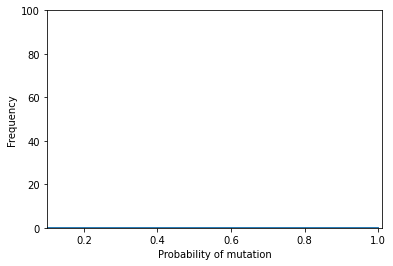

In [30]:
if __name__ == "__main__":

  #Genetic Algorithm
  print('Introduce an option:\n\n0.Basic GA\n1.GA with paralelism\n2.GA with cache\n3.GA with Hill Climbing\n4.Evaluate Hyperparameters\n5.Compara Algorithms')
  option = int(input())
  if option == 0:
    
    for i in range(0, 20):
      
      start = round(time.time() * 1000)
    
      population = geneticAlgorithm(nSolutions = 50, maxGenerations = 50 , mProb = 0.5,cProb=0.8,k=3,elitism=True, min_length = 7, max_length = 9)
      #population = geneticAlgorithm(nSolutions = 25, maxGenerations = 200 , mProb = 0.4,cProb=0.8,k=3,elitism=True, min_length = 10, max_length = 14)
      #population = geneticAlgorithm(nSolutions = 25, maxGenerations = 750 , mProb = 0.4,cProb=0.8,k=3,elitism=True, min_length = 15, max_length = 30)


      end = round(time.time() * 1000)

      finalTime = end - start

      population.sort(reverse=True,key=lambda population:population[1][0])

      for i in range(0,10):
        print(population[i])

      sum_frequency = 0
      sum_nEvents = 0

      best_frequency = 0
      worst_frequency = 100

      for i in range(0,10):
        sum_frequency += population[i][1][1]

        sum_nEvents += population[i][1][2]

        if population[i][1][1] > best_frequency:
          best_frequency = population[i][1][1]
        if population[i][1][1] < worst_frequency:
          worst_frequency = population[i][1][1]
    
      avg_frequency = sum_frequency/10

      avg_nEvents = sum_nEvents/10

      print(f"\nMean Frequency: {avg_frequency}\nMean Number of Events: {avg_nEvents}.")

      print(f"\nBest frequency: {best_frequency}\nWorst frequency: {worst_frequency}.")

      print(f"\nTime: {finalTime}")
  
  elif option == 1:

    for i in range(0, 20):
      
      start = round(time.time() * 1000)
    
      population = geneticAlgorithmMultiprocessing(nSolutions = 50, maxGenerations = 50 , mProb = 0.5,cProb=0.8,k=3,elitism=True, min_length = 7, max_length = 9)
      #population = geneticAlgorithmMultiprocessing(nSolutions = 25, maxGenerations = 200 , mProb = 0.4,cProb=0.8,k=3,elitism=True, min_length = 10, max_length = 14)
      #population = geneticAlgorithmMultiprocessing(nSolutions = 25, maxGenerations = 750 , mProb = 0.4,cProb=0.8,k=3,elitism=True, min_length = 15, max_length = 30)


      end = round(time.time() * 1000)

      finalTime = end - start

      population.sort(reverse=True,key=lambda population:population[1][0])

      for i in range(0,10):
        print(population[i])

      sum_frequency = 0
      sum_nEvents = 0

      best_frequency = 0
      worst_frequency = 100

      for i in range(0,10):
        sum_frequency += population[i][1][1]

        sum_nEvents += population[i][1][2]

        if population[i][1][1] > best_frequency:
          best_frequency = population[i][1][1]
        if population[i][1][1] < worst_frequency:
          worst_frequency = population[i][1][1]
    
      avg_frequency = sum_frequency/10

      avg_nEvents = sum_nEvents/10

      print(f"\nMean Frequency: {avg_frequency}\nMean Number of Events: {avg_nEvents}.")

      print(f"\nBest frequency: {best_frequency}\nWorst frequency: {worst_frequency}.")

      print(f"\nTime: {finalTime}")
  
  elif option == 2:

    for i in range(0, 20):
      
      start = round(time.time() * 1000)
    
      population = geneticAlgorithmCache(nSolutions = 50, maxGenerations = 50 , mProb = 0.5,cProb=0.8,k=3,elitism=True, min_length = 7, max_length = 9)
      #population = geneticAlgorithmCache(nSolutions = 25, maxGenerations = 200 , mProb = 0.4,cProb=0.8,k=3,elitism=True, min_length = 10, max_length = 14)
      #population = geneticAlgorithmCache(nSolutions = 25, maxGenerations = 750 , mProb = 0.4,cProb=0.8,k=3,elitism=True, min_length = 15, max_length = 30)


      end = round(time.time() * 1000)

      finalTime = end - start

      population.sort(reverse=True,key=lambda population:population[1][0])

      for i in range(0,10):
        print(population[i])

      sum_frequency = 0
      sum_nEvents = 0

      best_frequency = 0
      worst_frequency = 100

      for i in range(0,10):
        sum_frequency += population[i][1][1]

        sum_nEvents += population[i][1][2]

        if population[i][1][1] > best_frequency:
          best_frequency = population[i][1][1]
        if population[i][1][1] < worst_frequency:
          worst_frequency = population[i][1][1]
    
      avg_frequency = sum_frequency/10

      avg_nEvents = sum_nEvents/10

      print(f"\nMean Frequency: {avg_frequency}\nMean Number of Events: {avg_nEvents}.")

      print(f"\nBest frequency: {best_frequency}\nWorst frequency: {worst_frequency}.")

      print(f"\nTime: {finalTime}")

  elif option == 3:

    for i in range(0, 20):
      
      start = round(time.time() * 1000)
    
      population = geneticAlgorithmHillClimbing(nSolutions = 50, maxGenerations = 50 , mProb = 0.5,cProb=0.8,k=3,elitism=True, min_length = 7, max_length = 9)
      #population = geneticAlgorithmHillClimbing(nSolutions = 25, maxGenerations = 200 , mProb = 0.4,cProb=0.8,k=3,elitism=True, min_length = 10, max_length = 14)
      #population = geneticAlgorithmHillClimbing(nSolutions = 25, maxGenerations = 750 , mProb = 0.4,cProb=0.8,k=3,elitism=True, min_length = 15, max_length = 30)


      end = round(time.time() * 1000)

      finalTime = end - start

      population.sort(reverse=True,key=lambda population:population[1][0])

      for i in range(0,10):
        print(population[i])

      sum_frequency = 0
      sum_nEvents = 0

      best_frequency = 0
      worst_frequency = 100

      for i in range(0,10):
        sum_frequency += population[i][1][1]

        sum_nEvents += population[i][1][2]

        if population[i][1][1] > best_frequency:
          best_frequency = population[i][1][1]
        if population[i][1][1] < worst_frequency:
          worst_frequency = population[i][1][1]
    
      avg_frequency = sum_frequency/10

      avg_nEvents = sum_nEvents/10

      print(f"\nMean Frequency: {avg_frequency}\nMean Number of Events: {avg_nEvents}.")

      print(f"\nBest frequency: {best_frequency}\nWorst frequency: {worst_frequency}.")

      print(f"\nTime: {finalTime}")

  elif option == 4:
      fig, ax = plt.subplots()
      mProb = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

      mean_frequency, mean_nEvents, mean_time_exec = evaluationHyperparameters(mProb, hyperparameter = 2)
    
      plt.plot(mProb, mean_frequency)
    
      plt.ylim(0, 100)
      plt.xlim(0.1,1.01)
      plt.xlabel('Probability of mutation')
      plt.ylabel('Frequency')

  elif option == 5:

    intervals = [7,10,20]

    mean_frequency_basic, mean_nEvents_basic, mean_time_exec_basic, mean_frequency_hillclimbing, mean_nEvents_hillclimbing, mean_time_exec_hillclimbing, mean_frequency_cache, mean_nEvents_cache, mean_time_exec_cache = compareImplementations()

    fig=plt.figure(figsize=(8,6))


    ax1=fig.add_subplot(221)

    ax2=fig.add_subplot(222)
 
    ax3=fig.add_subplot(224)

    ax4 = fig.add_subplot(223)

    #AX1
    ax3.plot(intervals, mean_frequency_basic, color='red',label="GA with Elitism")
    ax3.set_ylim(0, 100)
    ax3.set_title("Frequency")

    ax3.plot(intervals, mean_frequency_hillclimbing, color='black',label="GA with HillClimbing and using cache")
    ax3.plot(intervals, mean_frequency_cache, color="green", label="GA with caching")
    ax3.legend()
    #AX2
    ax2.plot(intervals, mean_nEvents_basic, color='red')
    
    ax2.set_ylim(0, 6)
    ax2.set_title("NEvents")

    ax2.plot(intervals, mean_nEvents_hillclimbing, color='black')
    ax2.plot(intervals, mean_nEvents_cache, color="green")

    #AX1
    ax1.plot(intervals, mean_time_exec_basic, color='red')
    ax1.plot(intervals, mean_time_exec_cache, color="green")
    ax1.set_title("Execution time")

    #AX$
    ax4.plot(intervals, mean_time_exec_hillclimbing, color='black')
    ax4.set_title("Execution time")
  
    plt.tight_layout()
  else:
    print("Incorrect option")